In [1]:
import os
import sys

import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import plot


In [2]:
import django
# for django async setting
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ['DJANGO_ALLOW_ASYNC_UNSAFE'] = 'true'
django.setup()

In [3]:
# my util functions
from ra_exploer.views import filterQuery
from utils.TR2_tools import tr2_score

In [56]:
query = {
    'LC': ['LCT-15-1098', 'SLC19V33', 'LCT-19-580', 'N.A.'],
    'PI': ['ALL'],
    'Seal': ['ALL'],
}

vhr_df, vhr_mean_df = filterQuery(query, VHR)
adhesion_df, adhesion_mean_df = filterQuery(query, Adhesion)
lts_df, lts_mean_df = filterQuery(query, LowTemperatureStorage)
delta_angle_df, delta_angle_mean_df = filterQuery(
                query, DeltaAngle, 'lt')
pct_df, pct_mean_df = filterQuery(query, PressureCookingTest)
sealwvtr_df, sealwvtr_mean_df = filterQuery(query, SealWVTR)


In [57]:
df_LC = pd.DataFrame({'LC': ['LCT-15-1098', 'SLC19V33', 'LCT-19-580']})
df_PI = pd.DataFrame({'PI': ['RB005', 'RB205']})
df_seal = pd.DataFrame({'Seal': ['723K1M', '7142T', 'V386']})

In [58]:
df_LC_PI = df_LC.merge(df_PI, how='cross')
df = df_LC_PI.merge(df_seal, how='cross')

In [80]:
delta_angle_mean_df.head()

,item,LC,PI,Seal,Vender,value,configuration,score
0,Δ angle,LCT-19-580,RB005,N.A.,Nissan,0.13,LCT-19-580 RB005 N.A.,1.0
1,Δ angle,LCT-19-580,RB205,N.A.,Nissan,0.05,LCT-19-580 RB205 N.A.,10.0


In [59]:
adhesion_mean_df = adhesion_mean_df.groupby(by=['PI', 'Seal'], as_index=False).mean()
df = df.merge(adhesion_mean_df[['PI', 'Seal', 'score']], on=['PI', 'Seal'], how='left').rename(columns={'score': 'Adhesion'})

delta_angle_mean_df = delta_angle_mean_df.groupby(by=['LC', 'PI'], as_index=False).mean()
df = df.merge(delta_angle_mean_df[['LC', 'PI', 'score']], on=['LC', 'PI'], how='left').rename(columns={'score': 'Δ angle'})

vhr_mean_df = vhr_mean_df.groupby(by=['LC', 'PI', 'Seal'], as_index=False).mean()
df = df.merge(vhr_mean_df[['LC', 'PI', 'Seal', 'score']], on=['LC', 'PI', 'Seal'], how='left').rename(columns={'score': 'VHR'})

lts_mean_df = lts_mean_df.groupby(by=['LC'], as_index=False).mean()
df = df.merge(lts_mean_df[['LC', 'score']], on=['LC'], how='left').rename(columns={'score': 'LTS'})

pct_mean_df = pct_mean_df.groupby(by=['LC', 'PI', 'Seal'], as_index=False).mean()
df = df.merge(pct_mean_df[['LC', 'PI', 'Seal', 'score']], on=['LC', 'PI', 'Seal'], how='left').rename(columns={'score': 'PCT'})

sealwvtr_mean_df = sealwvtr_mean_df.groupby(by=['Seal'], as_index=False).mean()
df = df.merge(sealwvtr_mean_df[['Seal', 'score']], on=['Seal'], how='left').rename(columns={'score': 'Seal WVTR'})


In [60]:
# df.info()
df_fill0 = df.fillna(0)
df_fill0['Sum'] = df_fill0[['Adhesion', 'VHR', 'LTS', 'PCT', 'Seal WVTR']].sum(axis=1)
df_fill0 = df_fill0.sort_values(by='Sum', ascending=False)

In [61]:
df_fill0[:10]

,LC,PI,Seal,Adhesion,Δ angle,VHR,LTS,PCT,Seal WVTR,Sum
14,LCT-19-580,RB005,V386,6.000000,1.0,0.0,37.0,0.0,37.0,80.000000
17,LCT-19-580,RB205,V386,4.333333,28.0,0.0,37.0,0.0,37.0,78.333333
0,LCT-15-1098,RB005,723K1M,7.750000,0.0,37.0,1.0,0.0,30.0,75.750000
12,LCT-19-580,RB005,723K1M,7.750000,1.0,0.0,37.0,0.0,30.0,74.750000
15,LCT-19-580,RB205,723K1M,2.666667,28.0,0.0,37.0,0.0,30.0,69.666667
8,SLC19V33,RB005,V386,6.000000,0.0,0.0,19.0,0.0,37.0,62.000000
11,SLC19V33,RB205,V386,4.333333,0.0,0.0,19.0,0.0,37.0,60.333333
13,LCT-19-580,RB005,7142T,8.000000,1.0,0.0,37.0,0.0,12.0,57.000000
6,SLC19V33,RB005,723K1M,7.750000,0.0,0.0,19.0,0.0,30.0,56.750000
5,LCT-15-1098,RB205,V386,4.333333,0.0,0.0,1.0,10.0,37.0,52.333333


In [62]:
df_fill0['Configuration'] = df_fill0['LC'] + ' ' + df_fill0['PI'] + ' ' + df_fill0['Seal']

In [67]:
ra_plot_df = df_fill0[:10] \
    .set_index('Configuration')[['Adhesion', 'VHR', 'LTS', 'PCT', 'Seal WVTR', 'Sum']] \
    .unstack() \
    .reset_index() \
    .rename(columns={'level_0': 'Item', 0: 'Score'})

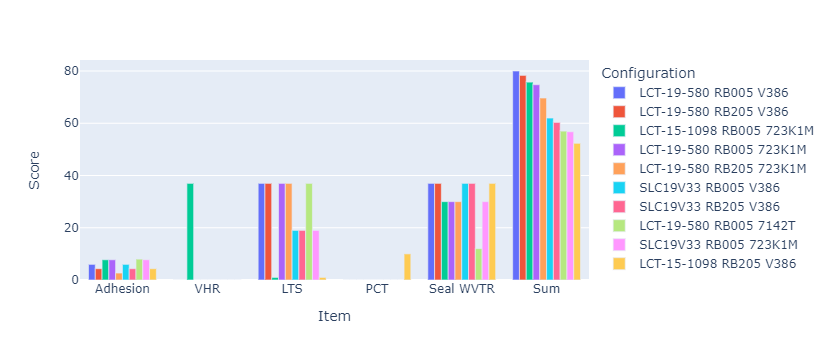

In [68]:
ra_fig = px.bar(
    ra_plot_df,
    x='Item',
    y='Score',
    color='Configuration',
    barmode='group'
)
ra_fig.show()

In [70]:
vhr_mean_df

,LC,PI,Seal,value,score
0,LCT-15-1098,RB005,7142T,83.9,15.0
1,LCT-15-1098,RB005,723K1M,89.0,37.0
2,LCT-15-1098,RB005,V386,80.5,1.0


In [75]:
pd.DataFrame({'PI': (list(Seal.objects.all().values_list('name', flat=True)))})

,PI
0,723K1M
1,7142T
2,V386
3,S-NP07
4,SNP07
5,N.A.
6,XN-5490H
7,SWH25
8,SSS42
